# Should I take a Cab?
### Estimating ridesharing and taxi prices in Chicago

Datasets used:
- https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew
- https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p


With the surge in popularity of ridesharing apps such as Uber and Lyft over traditional taxi services, consumers trade convenience for a general lack of transparency regarding prices. Ridesharing services often seem like a better deal than taxi services, but prices fluctuate drastically depending on demand and service choice. Companies such as Bellhop seek to make it easy for users to compare services, and can help users make choices between ridesharing and taxis in real time. I want to find a quantitative answer to the question of whether a given ridesharing price is fair given averages across services and taxi service. The ultimate goal is to build a predictive model of prices for both taxis and ridesharing and allow a user to see how that price compares to averages in their ride category.

Specifically, my proposal centers around two datasets: the recently released 'Transportation Network Providers' (TNP) data and 'Taxi-Trips' data from the city of Chicago government website. Analysis will focus on the most recent data (2018 in for the TNP and 2017 for the taxi trips). A project plan is listed below, with the initial analysis being performed in this notebook.

#### Initial work:

Exploratory analysis of the TNP and taxi dataset shows that the expected strong correlation between trip time/distance and price results in reasonable error of 3.7 and 5 dollars std error for the TNP and daxi dataset respectively. The benefit of using such a simple model is that it can be used to generate pricing rules of thumb between taxis and ridesharing, seen below:
    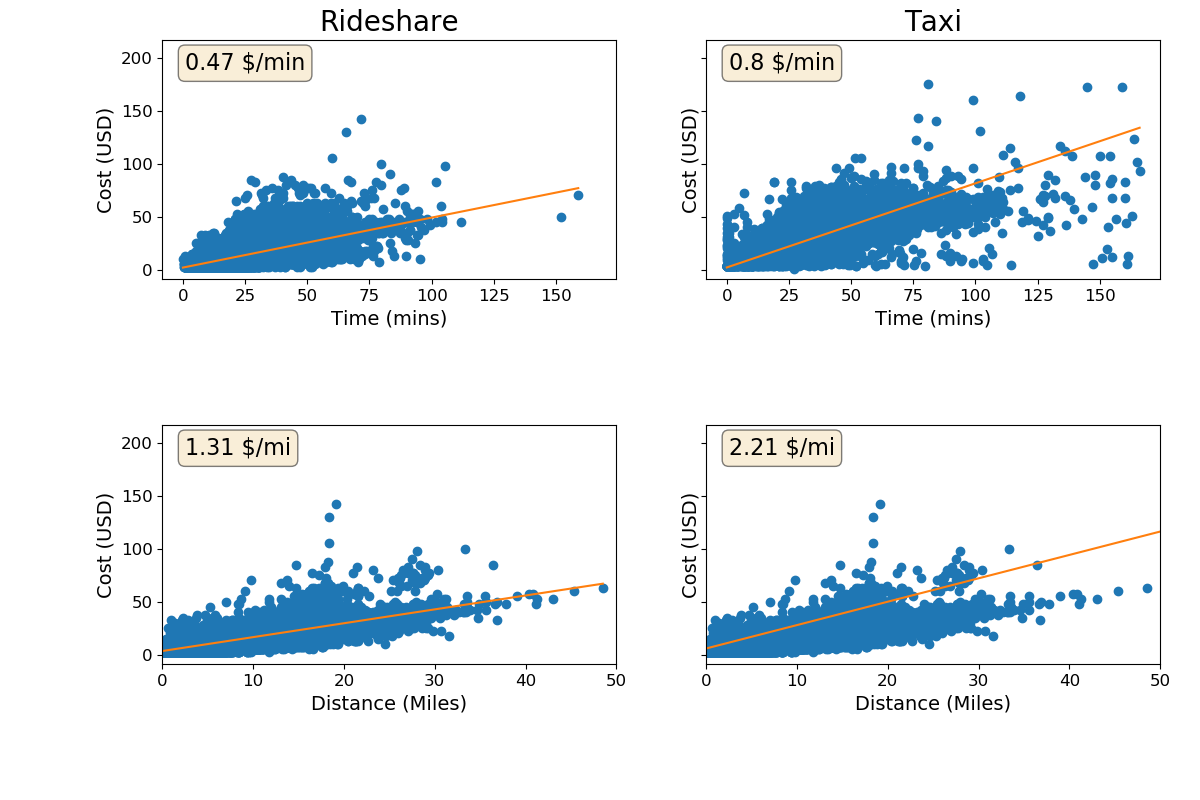

Using a linear price model for the TNP data, we can look at the estimated ridesharing fares for actual taxi trips. This is presented below:
    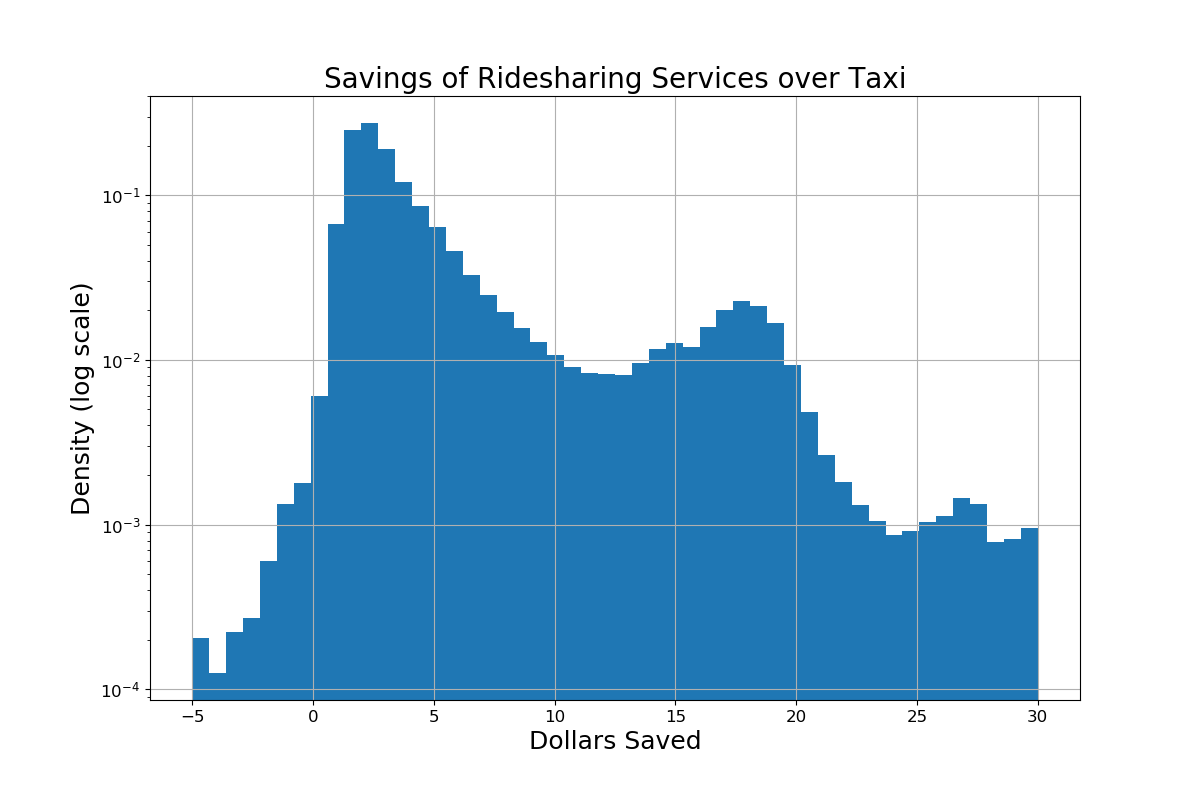
   This figure shows that ridesharing is almost always cheaper (given that less than 1% of rides show negative savings and the 3.6 dollar std. deviation of the model). That said, there are a significant number of rides where the cost between the two options is roughly the same, so the customer might be interested in when that is they case if they prefer taxis.

#### Planned work
- Use more sophisticated models (including categorical variables) to reduce the prediction error under cross-validation in both the taxi and TNP datasets. Use the model to see if there are other significant features in the dataset.
-  See if it's possible to generate rules of thumb for when taking a taxi is similar in cost to rideshare, and when ridesharing is a much better deal.
- Many ridesharing companies also provide a price estimate API, so it would make sense to see how well our estimates match theirs.
- Provide a web interface where a user can give their route information in chicago on a map. We tell them an estimated taxi/TNP price and they can compare their offers with that.


One issue: the taxi dataset ends in 2017. For now, we will compare prices over two months from both datasets. That is Jun and July 2017 in the taxi data and Nov. and Dec 2018 for the TNP dataset. At some point we can also see if the choice of the time window (in eg... winter) for the taxi dataset affects the model strongly.  

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
import random
#from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


### Loading and Preprocessing.
Let's load the taxi and TNP data. For this preliminary analysis, we'll leave the option to use a random sampling of the dataset to cut down on data size.

In [2]:
p = 0.2 # Percentage of dataset to keep

tnp = pd.read_csv(
         'Transportation_Network_Providers_-_Trips.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)

p = 1  # taxi usage is significantly smaller
taxi = pd.read_csv(
         'Taxi_Trips.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)


Dropping a lot of extra categorical and other variables for now, may add them later and see if they can help fit performance. We'll also drop columns with NaN's and values that don't make sense.

In [3]:
def preprocess_trip_data(df, unused_cols,max_fare = 200):
    df.columns = df.columns.str.replace(' ', '_') # for dot notation
    df.drop(unused_cols, axis=1, inplace=True)
    df.dropna(inplace = True)
    # Drop trips with outlier distances or times
    df.drop(df[(df.Trip_Miles <=0)|(df.Trip_Miles >100)].index, inplace=True)
    df.drop(df[(df.Trip_Seconds <=0)|(df.Trip_Seconds >int(1e4))].index, inplace=True)
    # drop unusually large or small fares
    df.drop(df[((df.Fare > 200) | (df.Fare <= 0))].index,inplace = True)
    # Convert datetimes
    df['Trip_Start_Timestamp']= pd.to_datetime(df['Trip_Start_Timestamp'],infer_datetime_format = True)
    return

print("Counts before preprocessing: ",tnp.count())

tnp_unused = ['Trip_ID','Trip_End_Timestamp','Pickup_Census_Tract', 'Dropoff_Census_Tract','Pickup_Community_Area', 
              'Dropoff_Community_Area','Tip','Additional_Charges', 'Trip_Total', 'Shared_Trip_Authorized',
              'Pickup_Centroid_Location', 'Dropoff_Centroid_Location','Trips_Pooled']

preprocess_trip_data(tnp,tnp_unused)

print("Counts after preprocessing: ",tnp.count())


Counts before preprocessing:  Trip ID                       3487894
Trip Start Timestamp          3487894
Trip End Timestamp            3487894
Trip Seconds                  3487444
Trip Miles                    3487894
Pickup Census Tract           2456972
Dropoff Census Tract          2441691
Pickup Community Area         3281325
Dropoff Community Area        3255072
Fare                          3487872
Tip                           3487894
Additional Charges            3487872
Trip Total                    3487872
Shared Trip Authorized        3487894
Trips Pooled                  3487894
Pickup Centroid Latitude      3283474
Pickup Centroid Longitude     3283474
Pickup Centroid Location      3283474
Dropoff Centroid Latitude     3257038
Dropoff Centroid Longitude    3257038
Dropoff Centroid Location     3257038
dtype: int64
Counts after preprocessing:  Trip_Start_Timestamp          3014261
Trip_Seconds                  3014261
Trip_Miles                    3014261
Fare            

In [4]:
taxi_unused = ['Trip_ID','Taxi_ID','Trip_End_Timestamp','Pickup_Census_Tract', 'Dropoff_Census_Tract','Pickup_Community_Area', 
                        'Dropoff_Community_Area','Tips','Tolls','Extras','Trip_Total','Payment_Type','Company',
                       'Pickup_Centroid_Location', 'Dropoff_Centroid__Location']
print("Counts before preprocessing: ",taxi.count())
preprocess_trip_data(taxi,taxi_unused)

print("Counts after preprocessing: ",taxi.count())

Counts before preprocessing:  Trip ID                       2018132
Taxi ID                       2016504
Trip Start Timestamp          2018132
Trip End Timestamp            2018025
Trip Seconds                  2017971
Trip Miles                    2018119
Pickup Census Tract           1282990
Dropoff Census Tract          1272944
Pickup Community Area         1868587
Dropoff Community Area        1823870
Fare                          2018119
Tips                          2018119
Tolls                         2018119
Extras                        2018119
Trip Total                    2018119
Payment Type                  2018132
Company                       1209511
Pickup Centroid Latitude      1868605
Pickup Centroid Longitude     1868605
Pickup Centroid Location      1868605
Dropoff Centroid Latitude     1827821
Dropoff Centroid Longitude    1827821
Dropoff Centroid  Location    1827821
dtype: int64
Counts after preprocessing:  Trip_Start_Timestamp          1483599
Trip_Seconds    

In [5]:
tnp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3014261 entries, 104 to 3487893
Data columns (total 8 columns):
Trip_Start_Timestamp          datetime64[ns]
Trip_Seconds                  float64
Trip_Miles                    float64
Fare                          float64
Pickup_Centroid_Latitude      float64
Pickup_Centroid_Longitude     float64
Dropoff_Centroid_Latitude     float64
Dropoff_Centroid_Longitude    float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 207.0 MB


### Preliminary Analysis: Average cost based on distance and time
Generally a user only cares about the price given a distance and time. Below we look at the distribution of these values and the correlation with the fare.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2a2037ccc0>,
      dtype=object)

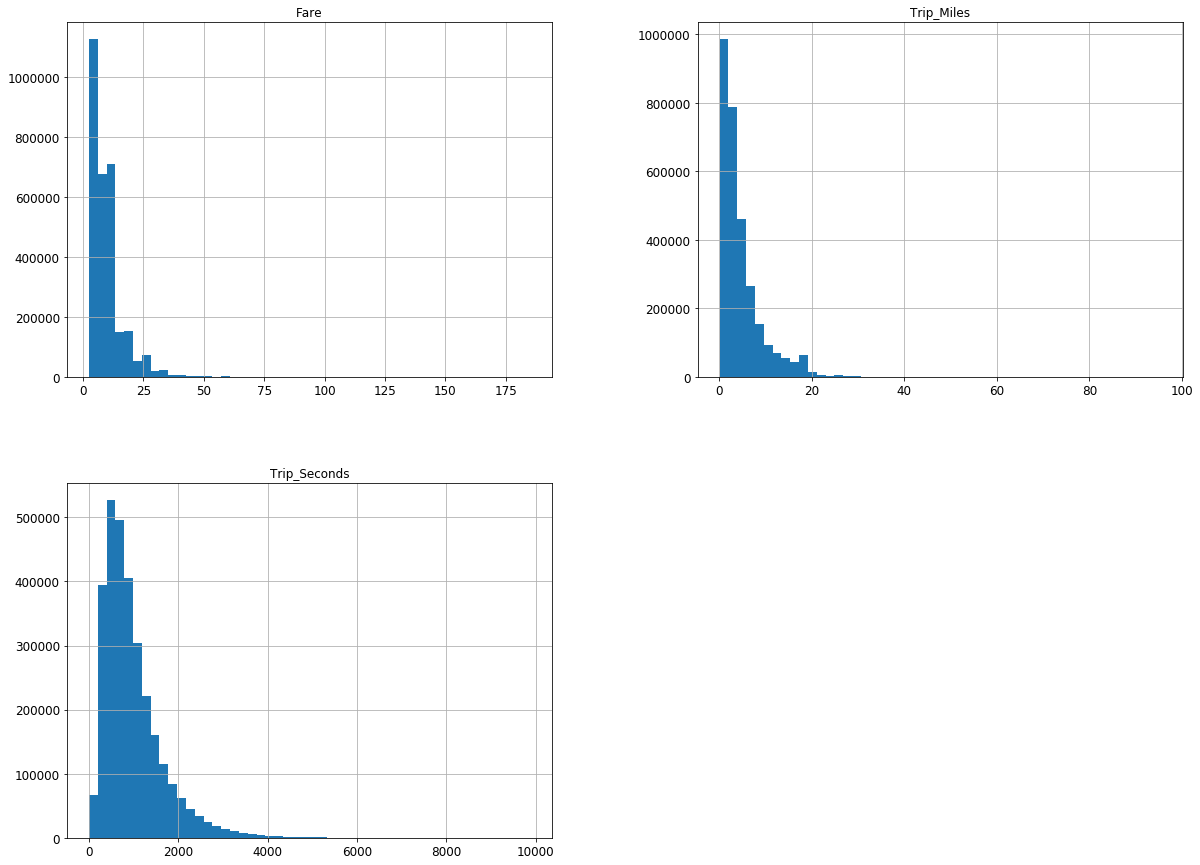

In [6]:
key_attributes = ['Fare','Trip_Seconds','Trip_Miles']
tnp[key_attributes].hist(bins = 50, figsize = (20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f29f65d6ef0>,
      dtype=object)

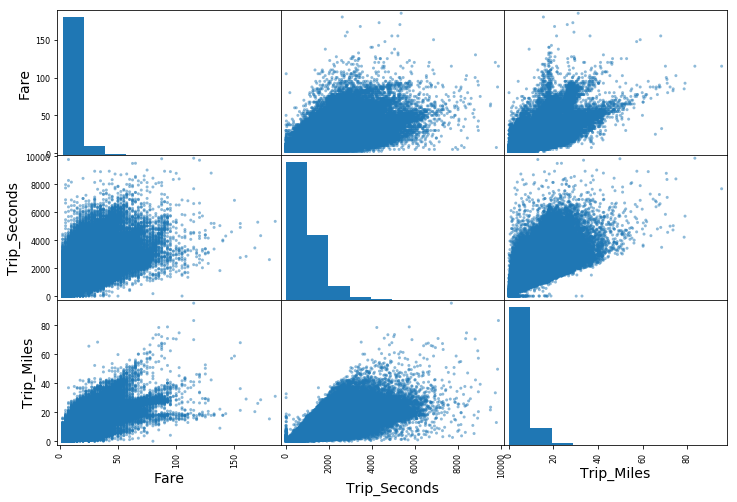

In [7]:
scatter_matrix(tnp[key_attributes],figsize = (12,8))

The fare is, as expected, heavily correlated with the duration and the length of the ride. Note in the Trip_Miles vs fare we see a few distinct linear trends. It's possible that these seperate service providers or 'rush pricing' categories. We will worry about that in the future using some of the categorical data available, but for now we will do a simple linear fit on these to get an average of the expected cost per time and distance.

In [9]:
# TODO: Replace this def with an sklearn pipline
def linear_time_distance_fit(df,x_params):
    y = df["Fare"].copy()
    X = df[x_params]
    lin_reg = LinearRegression()
    lin_reg.fit(X,y)
    lin_mse = mean_squared_error(y,lin_reg.predict(X))
    return lin_reg, lin_mse

def run_linear_fits(df):
    linmodel_mi, mse = linear_time_distance_fit(df,["Trip_Miles"])
    print("RMSE: ", np.sqrt(mse))
    print("Fit Coeffs", linmodel_mi.coef_)

    linmodel_sec, mse = linear_time_distance_fit(df,["Trip_Seconds"])
    print("RMSE: ", np.sqrt(mse))
    print("Fit Coeffs", linmodel_sec.coef_)

    linmodel, mse = linear_time_distance_fit(df,["Trip_Miles","Trip_Seconds"])
    print("RMSE: ", np.sqrt(mse))
    print("Fit Coeffs", linmodel.coef_)
    
    return linmodel_mi,linmodel_sec, linmodel
      
print("TNP Fits:")
tnp_linmodel_mi,tnp_linmodel_sec, tnp_linmodel = run_linear_fits(tnp)
print("\nTaxi Fits:")
taxi_linmodel_mi,taxi_linmodel_sec, taxi_linmodel = run_linear_fits(taxi)

TNP Fits:
RMSE:  3.7733926877714707
Fit Coeffs [1.30181711]
RMSE:  4.598854357848713
Fit Coeffs [0.00783377]
RMSE:  3.6859248864245333
Fit Coeffs [1.05060425 0.00207689]

Taxi Fits:
RMSE:  4.928964815966983
Fit Coeffs [2.2070545]
RMSE:  5.68388418580001
Fit Coeffs [0.01327214]
RMSE:  3.5800745252969204
Fit Coeffs [1.38042385 0.00658072]


We see that distance is a slightly better predictor than time, and that a joint model works best. The rmse is low enough to generate a 'rule of thumb' for average pricing given a distance or a time.

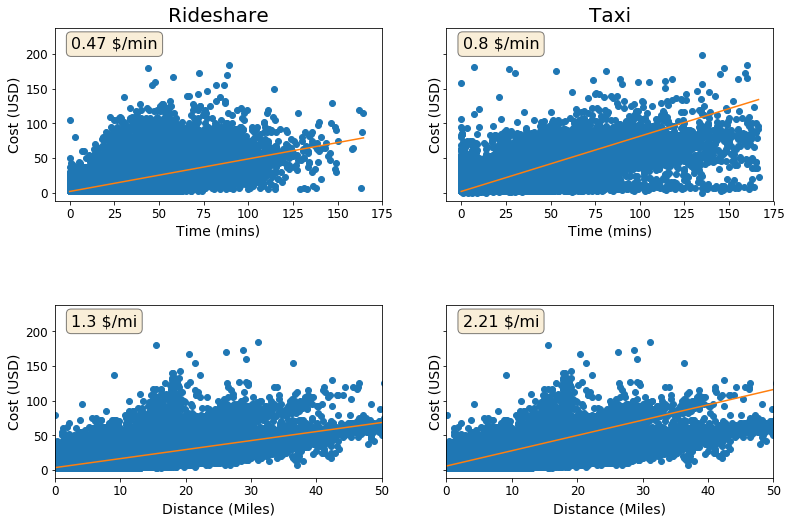

In [10]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


def plot_fits(df,model, axid, param = "Trip_Seconds"):
    fitx = np.linspace(0,df[param].values.max(),1000).reshape(-1,1)
    fity = model.predict(fitx)
    if param == "Trip_Seconds":
        axarr[axid].plot(df["Trip_Seconds"]/60,df["Fare"],'o')
        axarr[axid].plot(fitx/60,fity)
        axarr[axid].set_xlabel("Time (mins)")
        axarr[axid].set_ylabel("Cost (USD)")
        axarr[axid].text(0.05, 0.95, str(np.round(model.coef_[0]*60,2))+ " $/min", transform=axarr[axid].transAxes, fontsize=16,
        verticalalignment='top', bbox=props)
    else:
        axarr[axid].plot(tnp["Trip_Miles"],tnp["Fare"],'o')
        axarr[axid].plot(fitx,fity, label = 'hi')
        axarr[axid].set_xlabel("Distance (Miles)")
        axarr[axid].set_ylabel("Cost (USD)")
        axarr[axid].set_xlim([0,50])
        axarr[axid].text(0.05, 0.95, str(np.round(model.coef_[0],2))+ " $/mi", transform=axarr[axid].transAxes, fontsize=16,
        verticalalignment='top', bbox=props)

f, axarr = plt.subplots(2,2, sharey = True, sharex = 'row')
plot_fits(tnp,tnp_linmodel_sec,(0,0))
plot_fits(tnp,tnp_linmodel_mi,(1,0),"Trip_Miles")
plot_fits(taxi,taxi_linmodel_sec,(0,1))
plot_fits(taxi,taxi_linmodel_mi,(1,1),"Trip_Miles")
f.tight_layout()

axarr[0, 0].set_title('Rideshare', fontsize = 20)
axarr[0, 1].set_title('Taxi', fontsize = 20)

fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.savefig('Rideshare_vs_taxi.png', dpi=100)

Not surprisingly, the general rule of thumb is that the taxi is almost twice as expensive as the rideshare. However, the value of having all this data is to see if/when taking a taxi can be advantageous. We explore this in the next section.

In [ ]:
"""Unused code for now (since we have plenty of unused data for testing), will go in a full analysis.
#To perform better for larger fares, we'll use stratified sampling on the trip_miles.
tnp.Trip_Miles.hist(bins = 50, log = True)
# bin the trip length
plt.plot(tnp.Trip_Miles.sort_values().values)

cat_size = 3.
max_bin_dist = 30
tnp["distance_cat"]= np.ceil(tnp["Trip_Miles"]/cat_size) 

# lump all rides above 30 miles into category 
tnp["distance_cat"].where(tnp["distance_cat"]<max_bin_dist/cat_size,max_bin_dist/cat_size,inplace=True)
tnp["distance_cat"].value_counts()

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state = 1337)
for train_index, test_index in split.split(tnp,tnp["distance_cat"]):
    strat_train_set = tnp.iloc[train_index]
    strat_test_set = tnp.iloc[test_index]
    
    strat_train_set.plot(kind = "Scatter", x = "Pickup_Centroid_Longitude", y = "Pickup_Centroid_Latitude", alpha = 0.2,
            s = strat_train_set["Fare"], label = "Fare", figsize = (10,7),
            c = "Trip_Miles", cmap = plt.get_cmap('jet'),colorbar = True, sharex=False
)
plt.legend()
plt.show()
"""

### Predicting rideshare costs from equivalent taxi data
We will use a few more categories in a linear model of the TNP data. We evaluate the model performance, and then use it on the taxi data to estimate how much a rideshare of the same type would cost.

In [11]:
tnp_ride_features = tnp.copy()
tnp_fare_labels = tnp_ride_features['Fare'].copy()
tnp_ride_features.drop('Fare', axis = 1, inplace = True)
# specialize to the hour for timestaps:
tnp_ride_features['Trip_Start_Timestamp'] = tnp_ride_features.Trip_Start_Timestamp.dt.hour

In [12]:
print(tnp_ride_features.count(),tnp_fare_labels.count())

Trip_Start_Timestamp          3014261
Trip_Seconds                  3014261
Trip_Miles                    3014261
Pickup_Centroid_Latitude      3014261
Pickup_Centroid_Longitude     3014261
Dropoff_Centroid_Latitude     3014261
Dropoff_Centroid_Longitude    3014261
dtype: int64 3014261


In [13]:
lin_reg = LinearRegression()
lin_reg.fit(tnp_ride_features,tnp_fare_labels)

# Linear underfitting
from sklearn.metrics import mean_squared_error
fare_predictions = lin_reg.predict(tnp_ride_features)
lin_mse = mean_squared_error(tnp_fare_labels, fare_predictions)
print("RMSE: ", np.sqrt(lin_mse))

RMSE:  3.65543590067062


In [14]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

lin_scores = cross_val_score(lin_reg, tnp_ride_features, tnp_fare_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [3.6704193  3.67136214 3.65525849 3.68902416 3.6512742  3.64235984
 3.6300085  3.63269948 3.66220168 3.69565702]
Mean: 3.6600264813602523
Standard deviation: 0.021002214818852685


We see here that including several extra location and time-based features has only improved the model slightly over just using distance and time. They may become significantly more useful in a nonlinear model such as an svm, so different models should be tried in the future. Now we use this model on the taxi dataset:


In [15]:
taxi_ride_features = taxi.copy()
taxi_fare_labels = taxi_ride_features['Fare'].copy()
taxi_ride_features.drop('Fare', axis = 1, inplace = True)
# specialize to the hour for timestaps:
taxi_ride_features['Trip_Start_Timestamp'] = taxi_ride_features.Trip_Start_Timestamp.dt.hour

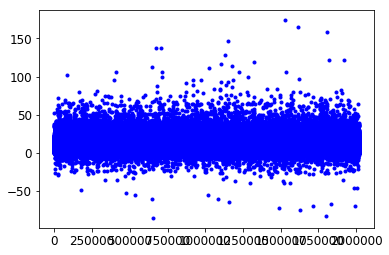

In [16]:
rideshare_estimate_on_taxi = lin_reg.predict(taxi_ride_features)
fare_difference = taxi_fare_labels-rideshare_estimate_on_taxi
plt.plot(fare_difference, 'b.')

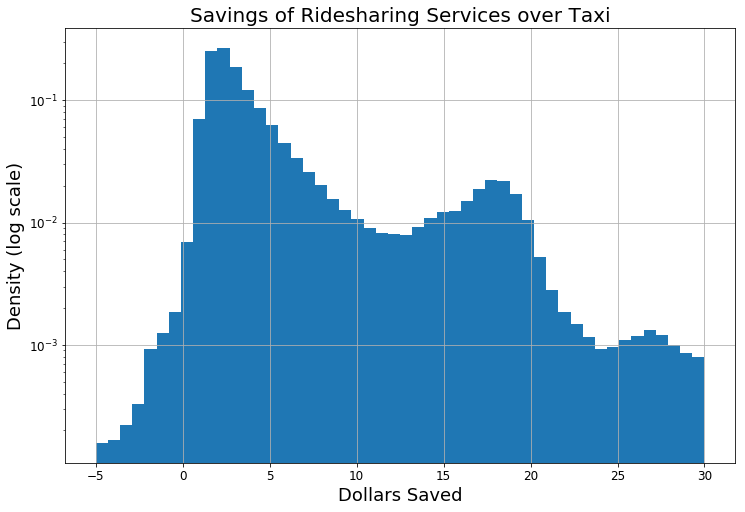

In [20]:
fare_difference.hist(bins = 50, figsize = (12,12),range=[-5,30], log = True,density = True)
plt.title("Savings of Ridesharing Services over Taxi", fontsize = 20)
plt.xlabel("Dollars Saved", fontsize = 18)
plt.ylabel("Density (log scale)", fontsize = 18)

fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.savefig('Rideshare_savings.png', dpi=100)

We see that the number of times the taxi seems to be a better deal is actually negligible (given the prediction standard deviation of ~3.5 $). That's a good argument for building a lower-error price estimator to see if we can narrow down the below-zero savings here.

The next step is exploring how this picture changes given certain conditions (including tips, longer rides, time of day... etc.).

The ultimate goal is to build accurate price predictors of both taxis and TNP's in chicago and give estimates for both services to a user in real time.

### Scratch work:

In [ ]:
taxi.dtypes
taxi['Trip_Start_Timestamp'] = pd.to_datetime(taxi['Trip_Start_Timestamp'],infer_datetime_format = True)

In [ ]:
cat_size = 3.
max_bin_dist = 30
taxi["distance_cat"]= np.ceil(taxi["Trip_Miles"]/cat_size) 

# lump all rides above 30 miles into category 
taxi["distance_cat"].where(taxi["distance_cat"]<max_bin_dist/cat_size,max_bin_dist/cat_size,inplace=True)

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state = 17)
for train_index, test_index in split.split(taxi,taxi["distance_cat"]):
    strat_train_set = taxi.iloc[train_index]
    strat_test_set = taxi.iloc[test_index]

In [ ]:
strat_train_set.dropna(inplace = True)
fare_labels_t = strat_train_set["Fare"].copy()
ride_features_t = strat_train_set.drop("Fare", axis = 1)
ride_features_t[ride_features_t.isnull().any(axis=1)].head() # Incomplete rows
ride_features_t.dropna(inplace = True)
# specialize to the hour for timestaps:
ride_features_t['Trip_Start_Timestamp'] = ride_features_t.Trip_Start_Timestamp.dt.hour


In [ ]:
print(ride_features_t.count(),fare_labels_t.count())

In [ ]:
lin_reg_t = LinearRegression()
lin_reg_t.fit(ride_features_t,fare_labels_t)

# quick test
some_data = ride_features.iloc[:10]
some_labels = fare_labels.iloc[:10]
print("Predictions: ",lin_reg.predict(some_data))
print("Labels: ",list(some_labels))

# Linear underfitting
fare_predictions_t = lin_reg_t.predict(ride_features_t)
lin_mse = mean_squared_error(fare_labels_t, fare_predictions_t)
print("RMSE: ", np.sqrt(lin_mse))

In [ ]:
taxi_estimate_on_ridesare = lin_reg_t.predict(ride_features)
rideshare_estimate_on_taxi = lin_reg.predict(ride_features_t)

In [ ]:
plt.plot(taxi_estimate_on_ridesare)
plt.plot(rideshare_estimate_on_taxi)

In [ ]:
taxi.Fare.hist(bins = 50, log = True)
tnp.Fare.hist(bins = 50)
tnp.Fare.max()

In [ ]:
plt.plot(fare_labels.values-taxi_estimate_on_ridesare, 'b.')
#plt.plot(taxi_estimate_on_ridesare)

In [ ]:
tnp_savings = (taxi_estimate_on_ridesare-fare_labels)
tnp_savings.hist(bins = 100,figsize = (12,12),range=[-10,20], density = True)
plt.title("Estimated savings of rideshare vs. Taxi", fontsize = 22)
plt.ylabel("Percentage out of ~1M rides")
plt.xlabel("Dollars saved")
print(tnp_savings.mean(),tnp_savings.std())

In [ ]:
((fare_labels_t-rideshare_estimate_on_taxi)).hist(bins = 50, figsize = (20,20),range=[-5,30])

In [ ]:
ride_features[(fare_labels-taxi_estimate_on_ridesare) >5].Trip_Miles.hist(bins = 50, figsize = (20,20))

In [ ]:
ride_features[(fare_labels-taxi_estimate_on_ridesare) <-5].Trip_Miles.hist(bins = 50, figsize = (20,20))

In [ ]:
good_taxi_rides = ride_features[(fare_labels-taxi_estimate_on_ridesare) >5]
good_tnp_rides = ride_features[(fare_labels-taxi_estimate_on_ridesare) <-5]

In [ ]:
good_tnp_rides.plot(kind = "Scatter", x = "Pickup_Centroid_Longitude", y = "Pickup_Centroid_Latitude", alpha = 0.2,
            s = strat_train_set["Fare"], label = "Fare", figsize = (10,7),
            c = "Trip_Miles", cmap = plt.get_cmap('jet'),colorbar = True, sharex=False
)
plt.legend()
plt.show()

In [ ]:
good_taxi_rides.plot(kind = "Scatter", x = "Pickup_Centroid_Longitude", y = "Pickup_Centroid_Latitude", alpha = 0.2,
            s = strat_train_set["Fare"], label = "Fare", figsize = (10,7),
            c = "Trip_Miles", cmap = plt.get_cmap('jet'),colorbar = True, sharex=False
)
plt.legend()
plt.show()

In [ ]:
play = ride_features.copy()

In [ ]:
play["cost_diff"] = np.ceil(10*(fare_labels-taxi_estimate_on_ridesare)/100)

In [ ]:
play.groupby("cost_diff").Trip_Seconds.mean()

In [ ]:
play.cost_diff.value_counts()

In [ ]:
play[(np.abs(play["cost_diff"])>3)]

### Measurering ride 'fairness' as deviation from the mean given distance, location and time.

In [ ]:
(fare_predictions - fare_labels).hist(bins = 50, range = [-20,20])

In [ ]:
ride_features[(fare_predictions - fare_labels)<-10].iloc[:10]

In [ ]:
fare_labels[(fare_predictions - fare_labels)<-10].iloc[:10]

In [ ]:
ride_features[(fare_predictions - fare_labels)>10].iloc[:10]

In [ ]:
fare_labels[(fare_predictions - fare_labels)>10].iloc[:10]

In [ ]:
lin_reg.coef_

In [ ]:
ride_features

### API related stuff (currently unused for initial analysis):

In [ ]:
query = ("https://data.cityofchicago.org/resource/m6dm-c72p.json")
raw_data = pd.read_json(query)

uname = 'bobmeetsabe@gmail.com'
APPTOK = 'leL1qsHufdxYHXCdRVR3FtdgN'

client = Socrata("data.cityofchicago.org",
                  APPTOK,
                  username=uname,
                  password="SsthSrZ65XFMW3e")

#results = client.get("m6dm-c72p", limit=int(1e6), order="trip_start_timestamp DESC")
#tnp = pd.DataFrame.from_records(results)